In [2]:
import numpy as np
import librosa
import IPython.display as ipd

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F

from torchvision.utils import make_grid 
import matplotlib.pyplot as plt         
from matplotlib.image import imread      
import random
from tqdm import tqdm 

In [3]:
def load_dataset(directory, batch_size, train_ratio=0.8):
    dataset = []
    emotion_to_number = {'NEU': 0, 'HAP': 1, 'SAD': 2, 'ANG': 3, 'DIS': 4, 'FEA': 5}
    max_len = 0
    
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            emotion = filename.split('_')[2]
            emotion_no = emotion_to_number[emotion]
            emotion_label = torch.zeros(6)
            emotion_label[emotion_no] = 1
            audio_tensor, _ = librosa.load(filepath, sr=None)
            max_len = max(max_len, len(audio_tensor))
            audio_tensor = torch.tensor(audio_tensor, dtype=torch.float32)
            dataset.append([audio_tensor, emotion_label])

    dataset = [(torch.nn.functional.pad(audio_tensor, (0, max_len - audio_tensor.size(0))), label)
               for audio_tensor, label in dataset]

    # Split the dataset into training and testing sets
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader objects for training and testing sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader


In [4]:
crema_d_directory = "./AudioWAV"
train_dataset, test_dataset, train_dataloader, test_dataloader = load_dataset(crema_d_directory, batch_size=32)
ex_audio, ex_label = train_dataset[random.randint(0,20)]
print(ex_audio)
print(ex_label)

tensor([-0.0042, -0.0032, -0.0035,  ...,  0.0000,  0.0000,  0.0000])
tensor([0., 0., 0., 1., 0., 0.])


In [5]:

class AudioCNN(nn.Module):

    def __init__(self, input_size, num_classes):
        super(AudioCNN, self).__init__()
        self.input_size = input_size
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Calculate the output size of the convolutional layers
        conv_output_size = (((input_size-2)//2) - 2)//2  # Considering two max pooling layers with kernel_size=2
        
        self.fc1 = nn.Linear(64 * conv_output_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [6]:

input_size = 80080
num_classes = 6  # 6 emotion classes

ex_audio, ex_label = train_dataset[random.randint(0,len(train_dataset))]

ex_audio = ex_audio.unsqueeze(0).unsqueeze(0)

test_model = AudioCNN(input_size=input_size, num_classes=6)
test_output = test_model(ex_audio)

print(test_output)
print(ex_label)
_,predicted = torch.max(test_output,0)
print(predicted)

tensor([[0.0032, 0.0000, 0.0039, 0.0369, 0.0215, 0.0083]],
       grad_fn=<ReluBackward0>)
tensor([0., 0., 0., 0., 0., 1.])
tensor([0, 0, 0, 0, 0, 0])


In [7]:
## Fill in the loss_function and optimizer below and run this cell to see if they are valid!

model = AudioCNN(input_size=input_size, num_classes=6)

loss_function = nn.CrossEntropyLoss()                      ## You should use CrossEntropyLoss, use the API to decide how to define this 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)      ## You can use SGD for this, which is defined in torch.optim -- look up some API stuff

#############################################

ex_audio, ex_label = train_dataset[random.randint(0,len(train_dataset))]

ex_audio = ex_audio.unsqueeze(0).unsqueeze(0)



# This checks that your model, loss and optimizer are valid -- checkout what they print!
print("BEFORE GRADIENT STEP:")
ex_pred = model(ex_audio) 
print("prediction:",ex_pred)
print("label:",ex_label)


optimizer.zero_grad() # Sets the gradient to 0 so that gradients don't stack together

ex_label = ex_label.argmax().unsqueeze(0)

ex_loss1 = loss_function(ex_pred, ex_label)
print("loss",ex_loss1)

ex_loss1.backward() # This gets the gradient of the loss function w.r.t all of your model's params

print()
print("AFTER GRADIENT STEP:")
optimizer.step() # This takes the step to train

ex_pred = model(ex_audio)
print("prediction:",ex_pred)
print("label:",ex_label)

ex_loss2 = loss_function(ex_pred, ex_label)
print("loss",ex_loss2.item())

print()
print("Difference in loss:", (ex_loss1 - ex_loss2))
print("This should be some positive number to say we reduced loss")

BEFORE GRADIENT STEP:
prediction: tensor([[0.0000, 0.0000, 0.0617, 0.0000, 0.1284, 0.0000]],
       grad_fn=<ReluBackward0>)
label: tensor([0., 0., 0., 1., 0., 0.])
loss tensor(1.8247, grad_fn=<NllLossBackward0>)

AFTER GRADIENT STEP:
prediction: tensor([[0.0000, 0.0000, 0.0511, 0.0000, 0.1174, 0.0000]],
       grad_fn=<ReluBackward0>)
label: tensor([3])
loss 1.8208308219909668

Difference in loss: tensor(0.0038, grad_fn=<SubBackward0>)
This should be some positive number to say we reduced loss


In [8]:
# training function here

def training(model, loss_function, optimizer, train_dataloader, n_epochs, update_interval):
    
    losses = []

    for n in range(n_epochs):
        for i, (audio, label) in enumerate(tqdm(iter(train_dataloader))):

            # TODO Complete the training loop using the instructions above
            # Hint: the above code essentially does one training step

            ##############################################################

            optimizer.zero_grad()
            audio = audio.unsqueeze(1)
            pred = model(audio)
            loss = loss_function(pred, label)
            loss.backward()
            optimizer.step()

            ##############################################################
        
            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss
        
    return model, losses

100%|██████████| 47/47 [10:38<00:00, 13.59s/it]


avg loss: 1.7903333333333327


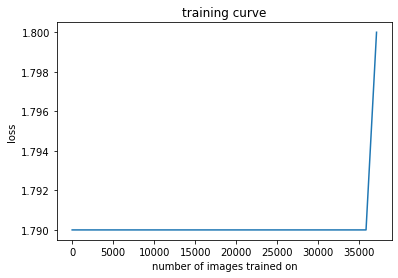

In [13]:
# Plug in your model, loss function, and optimizer 
# Try out different hyperparameters and different models to see how they perform
#train and tune

lr = 1e-4               # The size of the step taken when doing gradient descent
batch_size = 128       # The number of images being trained on at once
update_interval = 10   # The number of batches trained on before recording loss
n_epochs = 6            # The number of times we train through the entire dataset

input_size = 80080 #no change
num_classes = 6  # 6 emotion classes - no change

train_dataset, test_dataset, train_dataloader, test_dataloader = load_dataset(crema_d_directory, batch_size=batch_size)

model = AudioCNN(input_size=input_size, num_classes=num_classes)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

trained_model, losses = training(model, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)
 
print("avg loss:", sum(losses)/len(losses))

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

In [14]:
def test_accuracy(model, loss_function, test_data):

    '''
    This function will test the given model on the given test_data
    it will return the accuracy and the test loss (given by loss_function) 
    '''
    
    sum_loss = 0
    n_correct = 0
    total = 0

    for i, (audio, label) in enumerate(tqdm(iter(test_dataloader))):

        # This is essentially exactly the same as the training loop 
        # without the, well, training, part (and we record the accuracy too)
        audio = audio.unsqueeze(1)
        pred = model(audio)
        loss = loss_function(pred, label)
        sum_loss += loss.item()

        _, predicted = torch.max(pred,1)
        l = torch.argmax(label).item()
        n_correct += (predicted == l).sum()
        total += label.size(0)
    
    test_acc = round(((n_correct / total).item() * 100), 2)
    avg_loss = round(sum_loss / len(test_data), 2)

    print("test accuracy:", test_acc)
    print("test loss:", avg_loss )

    return test_acc, avg_loss

In [15]:
# To see how well your model is doing without hyperpameter tuning
test_acc,avg_loss = test_accuracy(model, loss_function, test_dataloader)

print("Testing accuracy of your first model:", test_acc)
print("Average loss of your first model:", avg_loss)

100%|██████████| 12/12 [01:38<00:00,  8.24s/it]


test accuracy: 25.79
test loss: 1.79
Testing accuracy of your first model: 25.79
Average loss of your first model: 1.79
